In [1]:
import pandas as pd
import csv
import re
import warnings
import time 
warnings.filterwarnings('ignore')

In [2]:
#file = "big_df_v2.csv"  #large file for production
file = "small_R_df.csv"       #small file for development
df = pd.read_csv('private/'+file, delimiter='|', encoding='latin-1')

In [3]:
#### stripping HTML tags ####
p = '<.*?>'
for col in df.columns:
    df[col] = df[col].replace(p, '', regex=True)

In [4]:
# splitting categories into main and sub, dropping non-Book main categories #
regex = r"\/(.*?)\/.*"

df['sub_cat'] = df['categoryPath'].str.extract(regex) # sub categories, one level below Books.
df['main_cat'] = df['categoryPath'].astype(str).str[:5] 
df = df[df.main_cat == 'Books'] #dropping non-Book categories

# drop rows missing critical data #
df = df.dropna(axis=0, how='any', subset=['longDn', 'sub_cat','name'])
df.isnull().sum().sort_values(ascending=False)

model           3358
shortDn           15
parentItemId      14
itemId            10
main_cat           0
sub_cat            0
catNode            0
longDn             0
categoryPath       0
name               0
dtype: int64

In [5]:
print("There are " + str(len(df.sub_cat.value_counts())) + " categories of books.")
counts = df['sub_cat'].value_counts()
threshold = 100
print(str(len(counts[counts>threshold])) + " categories have more than " + str(threshold) +" books.")

There are 47 categories of books.
4 categories have more than 100 books.


In [6]:
Top_40_cats = df.sub_cat.value_counts().iloc[:39].index.tolist()

# Print number of titles represented in each of the Top 40 categories #
print(df.sub_cat.value_counts().iloc[:39])


Arts & Entertainment Books                  1227
Children's & Kids' Books                     679
Business & Money Books                       467
Biographies & Memoirs                        453
Walmart Books Best Sellers                    73
Religion & Spirituality Books                 71
Literature & Fiction Books                    60
History Books                                 38
Crafts & Hobbies Books                        32
Back to School Books                          32
Self-Help Books                               28
Teen & Young Adult Books                      26
Comic Books & Graphic Novels                  26
Mother's Day Books                            21
Libros en Espanol                             20
Science & Nature Books                        19
Medical Books                                 17
Arts & Entertainment                          17
Cookbooks, Food & Wine                        16
Reference Books                               16
Education Books     

In [7]:
# Only keep records for top n populated categories (drop sparsely populated categories) #
df = df.loc[df['sub_cat'].isin(Top_40_cats)]

# Preparing Corpus and BOW for LDA Topic Modeling with Gensim
#### references used:
> http://mallet.cs.umass.edu/  
> https://radimrehurek.com/gensim/models/ldamodel.html  
> https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/  
> https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

In [8]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk#; nltk.download('stopwords')
#!python3 -m spacy download en

In [9]:
import numpy as np
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

# Fancy LDA visualization tool
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable gensim logging 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['book'])
#stop_words.extend(['book', 'new']) # decided extra stop words could be introducing bias 

In [11]:
# reviewing unique categories #
print(df.sub_cat.unique())

['Arts & Entertainment Books' "Children's & Kids' Books"
 'Business & Money Books' 'Cookbooks, Food & Wine'
 'Crafts & Hobbies Books' 'Walmart Books Best Sellers'
 'Literature & Fiction Books' 'Religion & Spirituality Books'
 "Mother's Day Books" 'Dieting & Fitness Books'
 'Study Aids & Test Prep Books' 'Health & Wellness Books'
 'Biographies & Memoirs' 'Reference Books' 'Humor Books'
 'Libros en Espanol' 'Computers & Technology Books'
 'Comic Books & Graphic Novels' 'Parenting & Family Books'
 'Teen & Young Adult Books' 'Medical Books' 'Self-Help Books'
 "Father's Day Books" 'History Books' 'Psychology & Social Science Books'
 'House, Home & Gardening Books' 'Travel Books' 'Education Books'
 "Women's History Month Books" 'Science & Nature Books'
 'Arts & Entertainment' 'Language Arts & Disciplines Books' 'Law Books'
 'Back to School Books' 'Foreign Language Study & Reference Books'
 'Mathematics Books' 'Political Books' 'Business & Money' 'Nonfiction']


In [12]:
data = df.longDn.values.tolist()

In [13]:
# converting contractions
data = [re.sub("won't","will not", sent) for sent in data]
data = [re.sub("can't","can not", sent) for sent in data]
data = [re.sub("n't","not", sent) for sent in data]
data = [re.sub("\'ll"," will", sent) for sent in data]
data = [re.sub("\'re"," are", sent) for sent in data]
data = [re.sub("\'ve"," have", sent) for sent in data]

# removing any single quotes
data = [re.sub("\'", " ", sent) for sent in data] 
# removing pipes to help with saving csv as pipe-delimited
data = [re.sub("\|", " ", sent) for sent in data]
# leave only letters and numbers (makes above lines redundant, but that's ok)
data = [re.sub("[^a-zA-Z0-9 ]", " ", sent) for sent in data]
# removing any extraneous spaces
data = [re.sub("\s+", " ", sent) for sent in data] #strip extra spaces

<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:12: DeprecationWarning: invalid escape sequence 

In [14]:
# random check to ensure clean data
data[300]

'New York Times bestseller More than Five million copies sold You CAN take control of your money Build up your money muscles with America s favorite finance coach Okay folks do you want to turn those fat and flabby expenses into a well toned budget Do you want to transform your sad and skinny little bank account into a bulked up cash machine Then get with the program people There s one sure way to whip your finances into shape and that s with The Total Money Makeover Classic Edition By now you have heard all the nutty get rich quick schemes the fiscal diet fads that leave you with a lot of kooky ideas but not a penny in your pocket Hey if you are tired of the lies and sick of the false promises take a look at this it s the simplest most straightforward game plan for completely making over your money habits And it s based on results not pie in the sky fantasies With The Total Money Makeover Classic Edition you will be able to Design a sure fire plan for paying off all debt meaning cars 

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [16]:
# Build the bigrams and trigrams
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [17]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [18]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:4])


C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])


In [19]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


# How many topics should we train? 

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA multiecore models
    coherence_values : Coherence values corresponding to the LDA multicore model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


"""    
    Warning: This WILL take a while 
"""
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=40, step=3)


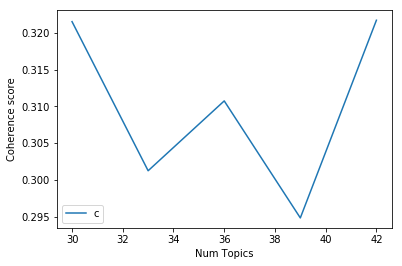

Num Topics = 30  has Coherence Value of 0.3215
Num Topics = 33  has Coherence Value of 0.3012
Num Topics = 36  has Coherence Value of 0.3107
Num Topics = 39  has Coherence Value of 0.2948
Num Topics = 42  has Coherence Value of 0.3217


In [21]:
# Show graph
start=10, limit=40, step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [22]:
############################################################
# comparing LDA model coherence scores vs. LDA Multicore
############################################################
#  As expected (and unexplained) LDA Model performs better
#  than the LDA multicore model with identical parameters 
############################################################


def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

"""    
    Warning: This WILL take a while 
"""
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)



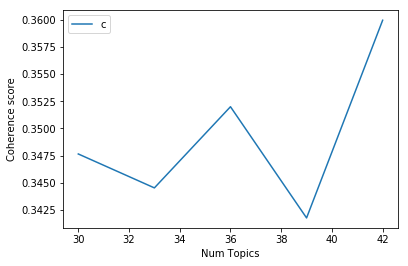

Num Topics = 30  has Coherence Value of 0.3477
Num Topics = 33  has Coherence Value of 0.3445
Num Topics = 36  has Coherence Value of 0.352
Num Topics = 39  has Coherence Value of 0.3418
Num Topics = 42  has Coherence Value of 0.36


In [23]:
# print graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


#          LDA Multicore results:   
big_df  
>  Num Topics = 30  has Coherence Value of 0.4437  
>  Num Topics = 33  has Coherence Value of 0.4106  
>  Num Topics = 36  has Coherence Value of 0.4513  
>  Num Topics = 39  has Coherence Value of 0.4462  
>  Num Topics = 42  has Coherence Value of 0.4425   

bigger_df:   
> Num Topics = 30  has Coherence Value of 0.4466  
> Num Topics = 33  has Coherence Value of 0.4341  
> Num Topics = 36  has Coherence Value of 0.4334  
> Num Topics = 39  has Coherence Value of 0.4356  
> Num Topics = 42  has Coherence Value of 0.4412  

#            LDA Model results:   
big_df  
> Num Topics = 30  has Coherence Value of 0.5116  
> Num Topics = 33  has Coherence Value of 0.5101  
> Num Topics = 36  has Coherence Value of 0.5146  
> Num Topics = 39  has Coherence Value of 0.4696  
>  Num Topics = 42  has Coherence Value of 0.4832  
 
bigger_df:  
> Num Topics = 30  has Coherence Value of 0.5535  
> Num Topics = 33  has Coherence Value of 0.4843  
> Num Topics = 36  has Coherence Value of 0.4783  
> Num Topics = 39  has Coherence Value of 0.4902  
> Num Topics = 42  has Coherence Value of 0.4779  
      
  As expected (and unexplained) LDA Model performs better   
  than the LDA multicore model with identical parameters   



# Attempting high score: Topics: 30, chunks: 50k, passes=20

> New Best Model? Yes  
> Runtime: 1 hour (3439 seconds)   
> Perplexity: -8.6129  
> Coherence Score: 0.6238   

added 'new' as stopword, coherence dropped to 0.603. Decision reversed.


In [24]:
def run_model(topics=30, chunksize=50000, passes=50):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=topics, 
                                               random_state=100,
                                               chunksize=chunksize,    # chunksize = number of docs to be used in each training chunk
                                               passes=passes,
                                               per_word_topics=True)

    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis,'vis_' + str(topics) + '.html')
    vis
    return;



In [25]:
#run_model(topics=30, chunksize=50000, passes=20)

# Attempting new high score: Topics: 30, chunks: 50k, passes=50

> New Best Model? Yes. Marginal improvement in Coherence Score (0.0034) by increasing from 20 to 50 passes.  
> Runtime: unclocked.   
> Perplexity: -8.609     
> Coherence Score: 0.6272     

added stopword 'new' and coherence decreased to 0.6078. Decision reversed.

In [26]:
run_model(topics=30, chunksize=50000, passes=50)


Perplexity:  -8.387340269308291

Coherence Score:  0.38945617304485775


C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:109: DeprecationWarning: invalid escape sequence \d
  nbits = re.compile('(\d+)bit').search(abits).group(1)
C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:662: DeprecationWarning: invalid escape sequence \s
  "\s+stepping\s+(?P<STP>\d+)", re.IGNORECASE)


# trying same best model, separate random state (100 -> 200)
Before:  
> Runtime: 3hrs 25 minutes (12,209 seconds).   
> Perplexity: -8.609     
> Coherence Score: 0.6272    
 
After (random state changed to 200):  
> Runtime: 2hrs 15min (8,111 seconds)  
> Perplexity: -8.603    
> Coherence Score: 0.611      

Results: Similar score, no improvement.

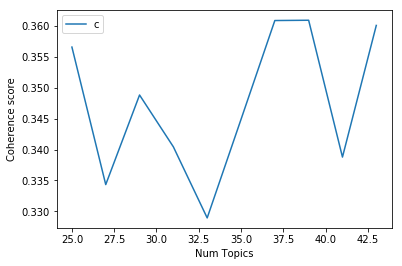

Num Topics = 25  has Coherence Value of 0.3566
Num Topics = 27  has Coherence Value of 0.3343
Num Topics = 29  has Coherence Value of 0.3488
Num Topics = 31  has Coherence Value of 0.3404
Num Topics = 33  has Coherence Value of 0.3289
Num Topics = 35  has Coherence Value of 0.3449
Num Topics = 37  has Coherence Value of 0.3609
Num Topics = 39  has Coherence Value of 0.3609
Num Topics = 41  has Coherence Value of 0.3388
Num Topics = 43  has Coherence Value of 0.3601


In [27]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=25, limit=45, step=2)

start=25; limit=45; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [28]:
run_model(topics=20, chunksize=40000, passes=50)


Perplexity:  -8.420061329381728

Coherence Score:  0.3729165035921527


In [29]:
run_model(topics=23, chunksize=40000, passes=50)


Perplexity:  -8.388969370828756

Coherence Score:  0.3877283966864842


In [30]:
run_model(topics=25, chunksize=50000, passes=50)


Perplexity:  -8.3784348989762

Coherence Score:  0.3608900227291966


In [31]:
run_model(topics=28, chunksize=50000, passes=50)


Perplexity:  -8.397491409919756

Coherence Score:  0.36483492649445015


In [32]:
run_model(topics=32, chunksize=50000, passes=50)


Perplexity:  -8.39829400567557

Coherence Score:  0.35956719340759025


In [33]:
run_model(topics=35 chunksize=50000, passes=50)

SyntaxError: invalid syntax (<ipython-input-33-666a795e3d91>, line 1)

In [ ]:
run_model(topics=37, chunksize=40000, passes=50)